# EE2073 Lab 4
### Author: Nguyen Hoang Khanh (Kelvin)

#### Question 1. Pre-built instruments

In [ ]:
# For use with VScope v1.4r1
# Law Choi Look     ecclaw@ntu.edu.sg           07 Mar 2022 v1.3
# Wonkeun Chang     wonkeun.chang@ntu.edu.sg    22 Jul 2023 v2.7

In [1]:
import serial
import serial.tools.list_ports

import threading
import time

import plotly
from ipywidgets import interactive_output,fixed,Button,ToggleButtons,SelectionSlider,IntSlider,FloatSlider,HTML,HBox,VBox,Label,Layout
from IPython.display import display

import numpy as np

VID=61525
PID=38912
BAUDRATE=115200
BUFFERSIZE=1000

In [2]:
# VScopeBoard class

class VScopeBoard:
    
    def __init__(self,vid=VID,pid=PID,baudrate=BAUDRATE):
        ports=serial.tools.list_ports.comports()
        for p in ports:
            if p.vid==vid and p.pid==pid:
                self.device=serial.Serial(p.device,baudrate=baudrate)
        if not hasattr(self,'device'):
            raise Exception('No controller unit detected')
        self.device.close()
        
        ###########################################################################
        # Enter your calbiration data below 
        # W1/W2 DC bias
        self.w1bias=0.249 # W1 DC bias reading in V; set it to 0 before calibrating
        self.w2bias=0.169 # W2 DC bias reading in V; set it to 0 before calibrating
        ###########################################################################
        # CH1/CH2: gain and offset look-up table
        # 'dc' calibrate at each vscale
        # 'dc'=-bias/'amp'+'dc'
        self.p1={0.02 :{'gain':224,'amp':0.0950,'dc':2.0,'dco':130,'dco_c2':171,'aco_c2':-0.005},
                 0.05 :{'gain':208,'amp':0.1500,'dc':1.91,'dco':130,'dco_c2':168,'aco_c2':-0.000},
                 0.1  :{'gain':160,'amp':0.3900,'dc':1.83,'dco':130,'dco_c2':159,'aco_c2':-0.020},
                 0.2  :{'gain':138,'amp':0.5500,'dc':1.81,'dco':130,'dco_c2':157,'aco_c2':-0.050},
                 0.5  :{'gain':220,'amp':2.1700,'dc':2.03,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 1    :{'gain':212,'amp':2.8500,'dc':1.98,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 2    :{'gain':160,'amp':7.9000,'dc':1.85,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 5    :{'gain':106,'amp':19.100,'dc':1.8,'dco':130,'dco_c2':130,'aco_c2':-0.000}}
        self.p2={0.02 :{'gain':224,'amp':0.0950,'dc':1.96,'dco':130,'dco_c2':171,'aco_c2':-0.025},
                 0.05 :{'gain':208,'amp':0.1500,'dc':1.89,'dco':130,'dco_c2':167,'aco_c2':-0.020},
                 0.1  :{'gain':160,'amp':0.3900,'dc':1.82,'dco':130,'dco_c2':159,'aco_c2':-0.040},
                 0.2  :{'gain':138,'amp':0.5500,'dc':1.81,'dco':130,'dco_c2':158,'aco_c2':-0.070},
                 0.5  :{'gain':220,'amp':2.1700,'dc':2.03,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 1    :{'gain':212,'amp':2.8500,'dc':1.97,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 2    :{'gain':160,'amp':7.9000,'dc':1.84,'dco':130,'dco_c2':130,'aco_c2':-0.000},
                 5    :{'gain':106,'amp':18.800,'dc':1.8,'dco':130,'dco_c2':130,'aco_c2':-0.000}}
        ############################################################################
    
    # Set DC power supply voltage VDCP and VDCN
    def set_vdc(self,voltage):
        cmd='dz'+str(int(voltage*100)).zfill(4)+'\r'
        self.device.open()
        self.device.reset_output_buffer()
        self.device.write(bytes(cmd,'utf-8'))
        self.device.close()
    
    # Generate waveforms on W1 and W2
    def generate_wave(self,channel,shape,amp,freq,offset):
        if channel==1:
            offset-=self.w1bias
            cmd='s1'
        else:
            offset-=self.w2bias
            cmd='s2'
        ns=64
        if shape=='Triangular':
            cmd+=str(10).zfill(2)
        elif shape=='Sawtooth':
            cmd+=str(11).zfill(2)
        else:
            cmd+=str(0).zfill(2)
        cmd+=str(ns).zfill(3)+str(freq).zfill(7)+str(int(amp*100)).zfill(4)+str(int(offset*100)).zfill(4)+'\r'
        self.device.open()
        self.device.reset_output_buffer()
        self.device.write(bytes(cmd,'utf-8'))
        self.device.close()
    
    # Capture oscilloscope traces on CH1 and CH2
    def capture_oscscope(self,tbase,vscale1,coupling1,vscale2,coupling2):
        if tbase>1100:
            fs=50000
        elif tbase>510:
            fs=100000
        else:
            fs=200000 # maximum sampling rate=210 kHz
        if coupling1=='DC':
            c1=0 if vscale1<0.4 else 1
        else:
            c1=2 if coupling1=='AC' else 3
        if coupling2=='DC':
            c2=0 if vscale2<0.4 else 1
        else:
            c2=2 if coupling2=='AC' else 3
        if c1==2:
            dco1=self.p1[vscale1]['dco_c2']
            aco1=self.p1[vscale1]['aco_c2']
        else:
            dco1=self.p1[vscale1]['dco']
            aco1=0
        if c2==2:
            dco2=self.p2[vscale1]['dco_c2']
            aco2=self.p2[vscale1]['aco_c2']
        else:
            dco2=self.p2[vscale1]['dco']
            aco2=0
        cmd='m1'+str(fs).zfill(6)+str(c1)+str(self.p1[vscale1]['gain']).zfill(3)+str(dco1).zfill(3)+str(c2)+str(self.p2[vscale2]['gain']).zfill(3)+str(dco2).zfill(3)+'\r'
        bytedata=bytearray(BUFFERSIZE*4)
        self.device.open()
        self.device.reset_output_buffer()
        self.device.reset_input_buffer()
        self.device.write(bytes(cmd,'utf-8'))
        self.device.readline()
        self.device.readinto(bytedata)
        self.device.close()
        data=np.frombuffer(bytedata,dtype='uint16').reshape((2,BUFFERSIZE))
        raw1=aco1+self.p1[vscale1]['amp']*(self.p1[vscale1]['dc']-1.5*data[0,:]/1700)
        raw2=aco2+self.p2[vscale2]['amp']*(self.p2[vscale2]['dc']-1.5*data[1,:]/1700)
        # Whittaer-Shannon interpolation for signal reconstruction on a finer grid within the tbase*10 range
        n=2**9
        t=np.arange(n)*10*tbase*1e-6/n
        ch1=np.sum(np.multiply(raw1,np.transpose(np.sinc(t*fs-np.reshape(np.arange(BUFFERSIZE),(BUFFERSIZE,1))))),axis=1)
        ch2=np.sum(np.multiply(raw2,np.transpose(np.sinc(t*fs-np.reshape(np.arange(BUFFERSIZE),(BUFFERSIZE,1))))),axis=1)
        return t,ch1,ch2,raw1,raw2
    
    # Measure DC voltage on PC0 and PC1
    def measure_volt(self):
        cmd='m2\r'
        bytedata=bytearray(4)
        self.device.open()
        self.device.reset_output_buffer()
        self.device.reset_input_buffer()
        self.device.write(bytes(cmd,'utf-8'))
        self.device.readline()
        self.device.readinto(bytedata)
        self.device.close()
        data=np.frombuffer(bytedata,dtype='uint16')
        v1=3.3*data[0]/4095
        v2=3.3*data[1]/4095
        return v1,v2

In [3]:
# RepeatTimer class

class RepeatTimer:

    def __init__(self,interval,function,*args,**kwargs):
        self.interval=interval
        self.function=function
        self.args=args
        self.kwargs=kwargs
        self.is_running=False
    
    def _run(self):
        self.is_running=False
        try:
            self.function(*self.args,**self.kwargs)
        except:
            pass
        self.start()
    
    def start(self):
        if not self.is_running:
            self._timer=threading.Timer(self.interval,self._run)
            self._timer.start()
            self.is_running=True
    
    def stop(self):
        try:
            self._timer.cancel()
            self.is_running=False
        except:
            pass

In [4]:
vscope=VScopeBoard()

In [ ]:
# # Calibrate CH1 and CH2 DC offset voltages
# # Work only in DC coupling mode
# # 1. Connect CH1 and CH2 pins to GND
# # 2. Execute all cells above
# # 3. Uncomment this cell and execute
# # 4. Note down the new 'dc' values and incorporate in the look-up table in capture_oscscope()
# # 5. Comment back this cell once completed

# n_calibrate=10
# vdiv_list=[0.02,0.05,0.1,0.2,0.5,1,2,5]
# ch1_dc=list()
# ch2_dc=list()
# for vdiv in vdiv_list:
#     _,_,_,y1,y2=vscope.capture_oscscope(1000,vdiv,'DC',vdiv,'DC')
#     for i in range(n_calibrate-1):
#         time.sleep(0.5)
#         _,_,_,ch1,ch2=vscope.capture_oscscope(1000,vdiv,'DC',vdiv,'DC')
#         y1+=ch1
#         y2+=ch2
#     y1/=n_calibrate
#     y2/=n_calibrate
#     ch1_dc.append(vscope.p1[vdiv]['dc']-np.mean(y1)/vscope.p1[vdiv]['amp'])
#     ch2_dc.append(vscope.p2[vdiv]['dc']-np.mean(y2)/vscope.p2[vdiv]['amp'])
#     print('Completed calibrating '+str(vdiv).rjust(4)+' V/Div')
# for i, vdiv in enumerate(vdiv_list):
#     print('\'dc\' CH1 '+str(vdiv).rjust(4)+' V/Div: '+str(round(ch1_dc[i],2)))
# for i, vdiv in enumerate(vdiv_list):
#     print('\'dc\' CH2 '+str(vdiv).rjust(4)+' V/Div: '+str(round(ch2_dc[i],2)))

Observed calibration result:
- Completed calibrating 0.02 V/Div
- Completed calibrating 0.05 V/Div
- Completed calibrating  0.1 V/Div
- Completed calibrating  0.2 V/Div
- Completed calibrating  0.5 V/Div
- Completed calibrating    1 V/Div
- Completed calibrating    2 V/Div
- Completed calibrating    5 V/Div
- 'dc' CH1 0.02 V/Div: 2.0
- 'dc' CH1 0.05 V/Div: 1.91
- 'dc' CH1  0.1 V/Div: 1.83
- 'dc' CH1  0.2 V/Div: 1.81
- 'dc' CH1  0.5 V/Div: 2.03
- 'dc' CH1    1 V/Div: 1.98
- 'dc' CH1    2 V/Div: 1.85
- 'dc' CH1    5 V/Div: 1.8
- 'dc' CH2 0.02 V/Div: 1.96
- 'dc' CH2 0.05 V/Div: 1.89
- 'dc' CH2  0.1 V/Div: 1.82
- 'dc' CH2  0.2 V/Div: 1.81
- 'dc' CH2  0.5 V/Div: 2.03
- 'dc' CH2    1 V/Div: 1.97
- 'dc' CH2    2 V/Div: 1.84
- 'dc' CH2    5 V/Div: 1.8

In [5]:
# DC voltage supply interface

vdc=FloatSlider(min=5.5,max=13.5,step=0.1,value=5.5,continuous_update=False,readout_format='.1f',layout=Layout(width='500px'))
vdc_ui=HBox([Label(value='VDCP/VDCN (±V)',layout=Layout(width='105px')),vdc],layout=Layout(justify_content='center',margin='5px 5px 5px 5px'))

ps_html='<h1 style=\'text-align:center;font-size:16px;background-color:lightcoral\'>Dual DC Voltage Supply</h1>'
ps_title=HTML(value=ps_html,layout=Layout(width='820px'))
ps_ui=HBox([vdc_ui],layout=Layout(justify_content='space-around',width='820px',height='44px'))

interactive_output(vscope.set_vdc,{'voltage':vdc})

Output()

In [6]:
# Waveform generator interface

shape1=ToggleButtons(options=['Sinusoidal','Triangular','Sawtooth'],value='Sinusoidal',style={'button_width':'80px'})
amp1=FloatSlider(min=0,max=5,step=0.01,value=0,readout_format='.2f',continuous_update=False)
freq1=IntSlider(min=100,max=50000,step=100,value=1000,continuous_update=False)
offset1=FloatSlider(min=-6,max=6,step=0.01,value=0,readout_format='.2f',continuous_update=False)

shape2=ToggleButtons(options=['Sinusoidal','Triangular','Sawtooth'],value='Sinusoidal',style={'button_width':'80px'})
amp2=FloatSlider(min=0,max=5,step=0.01,value=0,readout_format='.2f',continuous_update=False)
freq2=IntSlider(min=100,max=50000,step=100,value=1000,continuous_update=False)
offset2=FloatSlider(min=-6,max=6,step=0.01,value=0,readout_format='.2f',continuous_update=False)

shape1_ui=HBox([Label(value='Shape',layout=Layout(width='105px',display='flex',justify_content='flex-start')),shape1])
amp1_ui=HBox([Label(value='Amplitude (V)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),amp1])
freq1_ui=HBox([Label(value='Frequency (Hz)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),freq1])
offset1_ui=HBox([Label(value='Offset (V)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),offset1])

shape2_ui=HBox([Label(value='Shape',layout=Layout(width='105px',display='flex',justify_content='flex-start')),shape2])
amp2_ui=HBox([Label(value='Amplitude (V)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),amp2])
freq2_ui=HBox([Label(value='Frequency (Hz)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),freq2])
offset2_ui=HBox([Label(value='Offset (V)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),offset2])

wg1_ui=VBox([HTML('<h3 style=\'text-align:center;font-size:14px;margin-top:0px;margin-bottom:0px\'>W1</h3>'),shape1_ui,amp1_ui,freq1_ui,offset1_ui],layout=Layout(border='solid 2px',margin='5px 5px 5px 5px'))
wg2_ui=VBox([HTML('<h3 style=\'text-align:center;font-size:14px;margin-top:0px;margin-bottom:0px\'>W2</h3>'),shape2_ui,amp2_ui,freq2_ui,offset2_ui],layout=Layout(border='solid 2px',margin='5px 5px 5px 5px'))

wg_ui=HBox([wg1_ui,wg2_ui],layout=Layout(justify_content='space-around',width='820px',height='180px'))

wg_html='<h1 style=\'text-align:center;font-size:16px;background-color:lightblue\'>Waveform Generator</h1>'
wg_title=HTML(value=wg_html,layout=Layout(width='820px'))

interactive_output(vscope.generate_wave,{'channel':fixed(1),'shape':shape1,'amp':amp1,'freq':freq1,'offset':offset1})
interactive_output(vscope.generate_wave,{'channel':fixed(2),'shape':shape2,'amp':amp2,'freq':freq2,'offset':offset2})

Output()

In [7]:
# Oscilloscope interface

fig=plotly.graph_objs.FigureWidget()
fig.update_layout(width=380,height=410,margin=dict(l=2,r=2,t=2,b=32),paper_bgcolor='black',showlegend=False)
fig.update_layout(xaxis=dict(showticklabels=False,showgrid=True,gridwidth=1,gridcolor='black',zeroline=True,zerolinecolor='black'))
fig.update_layout(yaxis1=dict(tickmode='array',tickvals=[0],ticks='inside',tickwidth=2,tickcolor=plotly.colors.qualitative.Plotly[0],showticklabels=False,showgrid=False,zeroline=False))
fig.update_layout(yaxis2=dict(tickmode='array',tickvals=[0],ticks='inside',tickwidth=2,tickcolor=plotly.colors.qualitative.Plotly[1],showticklabels=False,showgrid=False,zeroline=False,overlaying='y1'))
fig.update_layout(yaxis3=dict(range=[-5,5],dtick=1,showticklabels=False,showgrid=True,gridwidth=1,gridcolor='black',zeroline=True,zerolinewidth=2,zerolinecolor='black',overlaying='y1'))
fig.add_trace(plotly.graph_objs.Scatter(x=[],y=[],name='CH1',yaxis='y1'))
fig.add_trace(plotly.graph_objs.Scatter(x=[],y=[],name='CH2',yaxis='y2'))
fig.add_trace(plotly.graph_objs.Scatter(x=[],y=[],yaxis='y3'))
fig.add_annotation(dict(font=dict(family='Courier New, monospace',color='white',size=10),x=0.5,y=-0.04,showarrow=False,text='',textangle=0,xanchor='center',xref='paper',yref='paper'))
fig.add_annotation(dict(font=dict(family='Courier New, monospace',color='white',size=10),x=0.5,y=-0.08,showarrow=False,text='',textangle=0,xanchor='center',xref='paper',yref='paper'))
fig.add_annotation(dict(font=dict(family='Courier New, monospace',color=plotly.colors.qualitative.Plotly[0],size=10),x=0.02,y=0.99,showarrow=False,text='',textangle=0,xanchor='left',xref='paper',yref='paper'))
fig.add_annotation(dict(font=dict(family='Courier New, monospace',color=plotly.colors.qualitative.Plotly[1],size=10),x=0.02,y=0.95,showarrow=False,text='',textangle=0,xanchor='left',xref='paper',yref='paper'))
fig.add_annotation(dict(font=dict(family='Courier New, monospace',color='black',size=10),x=0.98,y=0.99,showarrow=False,text='',textangle=0,xanchor='right',xref='paper',yref='paper'))

coupling1=ToggleButtons(options=['DC','AC','GND'],value='DC',style={'button_width':'80px'})
vscale1=SelectionSlider(options=[0.02,0.05,0.1,0.2,0.5,1,2,5],value=0.2,continuous_update=False)
vpos1=FloatSlider(min=-5,max=5,step=0.01,value=0,readout_format='.2f',continuous_update=False)

coupling2=ToggleButtons(options=['DC','AC','GND'],value='DC',style={'button_width':'80px'})
vscale2=SelectionSlider(options=[0.02,0.05,0.1,0.2,0.5,1,2,5],value=0.2,continuous_update=False)
vpos2=FloatSlider(min=-5,max=5,step=0.01,value=0,readout_format='.2f',continuous_update=False)

tbase=SelectionSlider(options=[20,50,100,200,500,1000,2000],value=500,continuous_update=False)

capture=Button(description='Capture',button_style='primary')

coupling1_ui=HBox([Label(value='Coupling',layout=Layout(width='105px',display='flex',justify_content='flex-start')),coupling1])
vscale1_ui=HBox([Label(value='Volts/Div',layout=Layout(width='105px',display='flex',justify_content='flex-start')),vscale1])
vpos1_ui=HBox([Label(value='Y-Pos.',layout=Layout(width='105px',display='flex',justify_content='flex-start')),vpos1])

coupling2_ui=HBox([Label(value='Coupling',layout=Layout(width='105px',display='flex',justify_content='flex-start')),coupling2])
vscale2_ui=HBox([Label(value='Volts/Div',layout=Layout(width='105px',display='flex',justify_content='flex-start')),vscale2])
vpos2_ui=HBox([Label(value='Y-Pos.',layout=Layout(width='105px',display='flex',justify_content='flex-start')),vpos2])

tbase_ui=HBox([Label(value='Time/Div (μS)',layout=Layout(width='105px',display='flex',justify_content='flex-start')),tbase],layout=Layout(margin='7px 7px 7px 7px'))

osc1=VBox([HTML('<h3 style=\'text-align:center;font-size:14px;margin-top:0px;margin-bottom:0px\'>CH1</h3>'),coupling1_ui,vscale1_ui,vpos1_ui],layout=Layout(border='solid 2px',margin='5px 5px 5px 5px'))
osc2=VBox([HTML('<h3 style=\'text-align:center;font-size:14px;margin-top:0px;margin-bottom:0px\'>CH2</h3>'),coupling2_ui,vscale2_ui,vpos2_ui],layout=Layout(border='solid 2px',margin='5px 5px 5px 5px'))
osc3=VBox([tbase_ui,capture],layout=Layout(align_items='center'))
osc_ui=HBox([VBox([fig],layout=Layout(justify_content='space-around')),VBox([osc1,osc2,osc3],layout=Layout(justify_content='space-around'))],layout=Layout(justify_content='space-around',width='820px',height='420px'))

osc_html='<h1 style=\'text-align:center;font-size:16px;background-color:lightgreen\'>Oscilloscope</h1>'
osc_title=HTML(value=osc_html,layout=Layout(width='820px'))

def calchar(y,dt,tbase):
    n_avg=5
    y=np.convolve(y,np.ones(n_avg),mode='valid')/n_avg # moving average
    rms=np.sqrt(np.mean(y**2))
    ptp=np.ptp(y) 
    if tbase<510:
        y=np.pad(y,(0,int(0.01*len(y)/(10*tbase*1e-6))-len(y)),'constant') # ensure frequency resolution < 100 Hz
    freq=np.abs(np.fft.fftfreq(len(y))[np.argmax(np.abs(np.fft.fft(y-np.mean(y))))]/dt)
    return rms,freq,ptp

def txtchar(ch,rms,freq,ptp):
    text='CH1    ' if ch==1 else 'CH2    '
    text=text+'RMS: {0:6.2f} mV    '.format(rms*1e3) if rms<1 else text+'RMS: {0:6.2f} V     '.format(rms)
    text=text+'Freq: {0:6.3f} kHz    '.format(freq*1e-3) if freq>1e3 else text+'Freq: {0:6.0f} Hz     '.format(freq)
    text=text+'Vpp: {0:6.2f} mV'.format(ptp*1e3) if ptp<1 else text+'Vpp: {0:6.2f} V '.format(ptp)
    return text

def capture_oscscope(empty=None):
    if coupling1.value=='AC' and vscale1.value>0.4:
        print('Only DC coupling is available for V/Div > 0.5. Selecting DC coupling for CH1.')
        coupling1.value='DC'
    if coupling2.value=='AC' and vscale2.value>0.4:
        print('Only DC coupling is available for V/Div > 0.5. Selecting DC coupling for CH2.')
        coupling2.value='DC'
    t,ch1,ch2,_,_=vscope.capture_oscscope(tbase.value,vscale1.value,coupling1.value,vscale2.value,coupling2.value)
    fig.data[0]['x']=fig.data[1]['x']=t
    fig.data[0]['y']=ch1
    fig.data[1]['y']=ch2
    fig.update_layout(xaxis=dict(range=[0,10*tbase.value*1e-6],dtick=tbase.value*1e-6))
    fig.update_layout(yaxis1=dict(range=[vscale1.value*(-vpos1.value-5),vscale1.value*(-vpos1.value+5)]))
    fig.update_layout(yaxis2=dict(range=[vscale2.value*(-vpos2.value-5),vscale2.value*(-vpos2.value+5)]))
    rms1,freq1,ptp1=calchar(ch1,t[1],tbase.value)
    rms2,freq2,ptp2=calchar(ch2,t[1],tbase.value)
    fig.update_layout(annotations=[dict(text=txtchar(1,rms1,freq1,ptp1)),dict(text=txtchar(2,rms2,freq2,ptp2)),dict(text='CH1: {0:4.2f} V/Div'.format(vscale1.value)),dict(text='CH2: {0:4.2f} V/Div'.format(vscale2.value)),dict(text=str(tbase.value)+' μs/Div')])

capture_oscscope()

capture.on_click(capture_oscscope)
tbase.observe(capture_oscscope,'value')
vscale1.observe(capture_oscscope,'value')
vpos1.observe(capture_oscscope,'value')
coupling1.observe(capture_oscscope,'value')
vscale2.observe(capture_oscscope,'value')
vpos2.observe(capture_oscscope,'value')
coupling2.observe(capture_oscscope,'value')

In [8]:
display(ps_title,ps_ui)
display(wg_title,wg_ui)
display(osc_title,osc_ui)

HTML(value="<h1 style='text-align:center;font-size:16px;background-color:lightcoral'>Dual DC Voltage Supply</h…

HTML(value="<h1 style='text-align:center;font-size:16px;background-color:lightblue'>Waveform Generator</h1>", …

HTML(value="<h1 style='text-align:center;font-size:16px;background-color:lightgreen'>Oscilloscope</h1>", layou…

    'data': [{'name': 'CH1',
              'type': 'scatter',
   …

Observations:
- Digital multimeter reflects correctly any change in the DC Voltage supply setting.
- Oscilloscope reflects the expected waveform, but the numerical values are deflected from the expected value. Also, the waveforms are with DC offset unexpectedly.
- 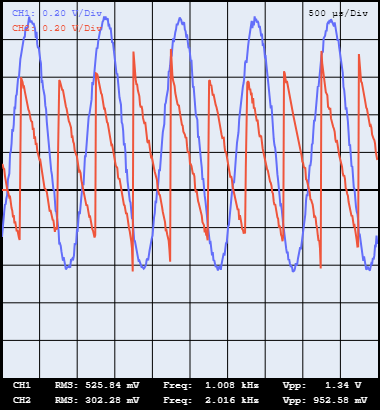

#### Question 2. Waveform generators DC offset calibration

Observation:
- W1 DC offset = 0.249 V
- W2 DC offset = 0.169 V\
After calibration:
- W1 DC offset = 0.007 V
- W2 DC offset = 0.006 V\
Both of them are close to zero. The offset sliders on the generator also function as expected.


#### Question 3. Oscilloscope offset calibration

Observation:
- The plots now look more correct, although the numerical value is still a little deflected from the expected value.
- 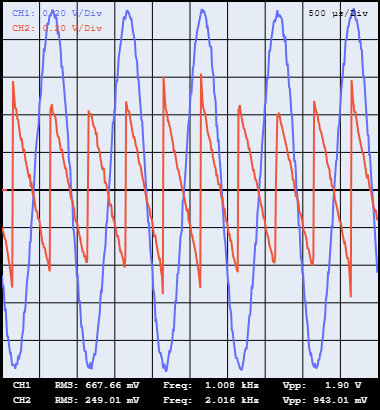

#### Open-ended question

- `amp` is the amplification factor. It represents the conversion factor between raw ADC values and actual voltage levels. Higher `amp` value allows the oscilloscope to capture higher voltage values.
- `dc` represents the reference voltage level, which is a baseline in the reading.
- The calibration routine works for each V/div scale by capturing the average number of raw1 and raw2 after the iteration. Then, the result is returned by subtracting that raw value divided by the `amp` from the extracted `dc` from the lookup table.